# Run & Analysis: Role-Assumed Replay Experiments

This notebook provides runnable cells to:

1. Launch the experiment driver (`scripts/ablation_driver.py`) with configurable model/limits.
2. Load and visualize the resulting `results/role_assume_ablation/summary.csv` and JSONL outputs.

Notes: On Windows, large models (e.g., `gpt2-large` or bigger) may exhaust pagefile/RAM. Use smaller models or the `bitsandbytes` 8-bit workflow to reduce memory.

In [ ]:
# Cell 1: Run experiments via the driver
import subprocess, sys, shlex, os
from pathlib import Path

def run_ablation(model='gpt2-medium', limit=100, turns=(1,2), both=False, batch_size=5, teacher='tmp/role_assume_teacher_5.jsonl'):
    turns_arg = ' '.join(str(t) for t in turns)
    cmd = [sys.executable, 'scripts/ablation_driver.py', '--teacher', teacher, '--model', model, '--limit', str(limit), '--turns'] + [str(t) for t in turns]
    if both:
        cmd.append('--both')
    # set a reasonable batch size
    cmd += ['--batch-size', str(batch_size)]
    print('Running:', ' '.join(shlex.quote(c) for c in cmd))
    try:
        subprocess.run(cmd, check=True)
    except subprocess.CalledProcessError as e:
        print('Experiment failed with return code', e.returncode)
        print('See the subprocess output above for details.')
    except OSError as e:
        print('OS error while launching experiment:', e)
        if 'paging' in str(e).lower() or 'pagefile' in str(e).lower():
            print('Pagefile/virtual memory error: consider using a smaller model, lowering --limit, or enabling 8-bit loading with bitsandbytes.')

# Example: run with gpt2-medium to avoid Windows pagefile issues
# run_ablation(model='gpt2-medium', limit=100, turns=(1,2), both=False)

print('Ready — call run_ablation(...) to start experiments from this notebook.')

In [ ]:
# Cell 2: Optional helper to check/install bitsandbytes (8-bit) support
import importlib, sys
def check_bitsandbytes():
    try:
        import bitsandbytes as bnb
        print('bitsandbytes available, version', bnb.__version__)
    except Exception:
        print('bitsandbytes not installed. To install:')
        print('pip install -U bitsandbytes accelerate transformers')
        print('Then restart the kernel and re-run the experiment with load_in_8bit support.')

check_bitsandbytes()

In [ ]:
from pathlib import Path

run_ablation(model='gpt2-medium', limit=100, turns=(1,2), both=False, batch_size=5)

Loaded from c:\Users\Gabriele\Desktop\AML_FinalProject\SubliminalLearning\results\role_assume_ablation\summary.csv
         mode condition  turns  \
0  restricted      none      1   
1  restricted    system      1   
2  restricted      user      1   
3  restricted      none      2   
4  restricted    system      2   
5  restricted      user      2   

                                            out_path  n  detected  percent  \
0  results\role_assume_ablation\role-none_turns-1...  5         0      0.0   
1  results\role_assume_ablation\role-system_turns...  5         0      0.0   
2  results\role_assume_ablation\role-user_turns-1...  5         0      0.0   
3  results\role_assume_ablation\role-none_turns-2...  5         0      0.0   
4  results\role_assume_ablation\role-system_turns...  5         0      0.0   
5  results\role_assume_ablation\role-user_turns-2...  5         0      0.0   

   avg_prob  hallucination_rate  
0  0.004494                 NaN  
1  0.003608                 NaN

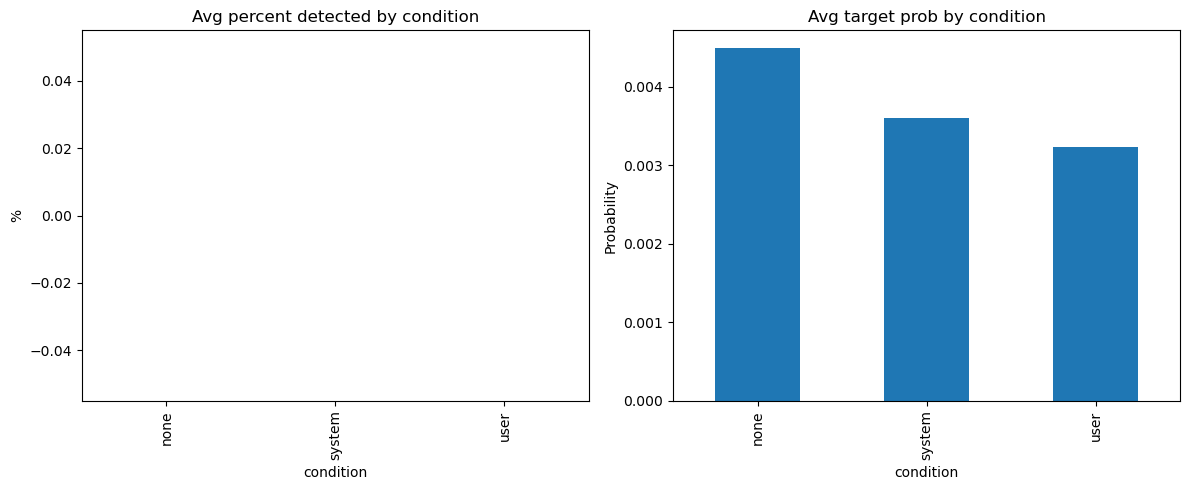


Summary by condition:
             n      detected      percent       avg_prob     
          mean  std     mean  std    mean  std      mean  std
condition                                                    
none       5.0  0.0      0.0  0.0     0.0  0.0  0.004494  0.0
system     5.0  0.0      0.0  0.0     0.0  0.0  0.003608  0.0
user       5.0  0.0      0.0  0.0     0.0  0.0  0.003234  0.0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Try multiple possible paths
possible_paths = [
    Path('results/role_assume_ablation/summary.csv'),
    Path('/home/gabrivol/subliminal-learning/results/role_assume_ablation/summary.csv'),
    Path.cwd().parent / 'results/role_assume_ablation/summary.csv'
]

csv_path = None
for p in possible_paths:
    if p.exists():
        csv_path = p
        break

if csv_path is None:
    print('Summary CSV not found. Searched:', possible_paths)
    print('Current working directory:', Path.cwd())
else:
    df = pd.read_csv(csv_path)
    print(f'Loaded from {csv_path}')
    print(df)
    print()
    
    # Create plots grouped by condition
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    df_grouped = df.groupby('condition')[['percent', 'avg_prob']].mean()
    df_grouped['percent'].plot(kind='bar', ax=ax[0], title='Avg percent detected by condition', ylabel='%')
    df_grouped['avg_prob'].plot(kind='bar', ax=ax[1], title='Avg target prob by condition', ylabel='Probability')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print('\nSummary by condition:')
    print(df.groupby('condition')[[ 'n', 'detected', 'percent', 'avg_prob' ]].agg(['mean', 'std']))


In [3]:
import json
import numpy as np
from scipy import stats
from pathlib import Path

# Load individual JSONL results for bootstrap significance test
def find_repo_root():
    p = Path.cwd()
    for _ in range(10):
        if (p / 'pyproject.toml').exists() or (p / 'scripts').exists() or (p / '.git').exists():
            return p
        if p.parent == p:
            break
        p = p.parent
    return None

def load_jsonl(path):
    rows = []
    p = Path(path)
    repo_root = find_repo_root()
    candidates = [
        p,
        Path.cwd() / path,
    ]
    if repo_root is not None:
        candidates += [repo_root / path, repo_root / 'results' / 'role_assume_ablation' / Path(path).name]
    # also try the workspace-local results folder
    candidates.append(Path('results/role_assume_ablation') / Path(path).name)
    found = None
    for c in candidates:
        try:
            if c.exists():
                found = c
                break
        except Exception:
            pass
    # Glob as a fallback under results folder
    if found is None:
        resdir = (repo_root / 'results' / 'role_assume_ablation') if repo_root is not None else Path('results/role_assume_ablation')
        if resdir.exists():
            for f in resdir.glob(f'*{Path(path).name}'):
                found = f
                break
    if found is None or not found.exists():
        raise FileNotFoundError(f'Could not find {path}. Searched: ' + ', '.join(str(x) for x in candidates))
    with open(found, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    return rows

# Load conditions
none_turns1 = load_jsonl('results/role_assume_ablation/role-none_turns-1.jsonl')
system_turns1 = load_jsonl('results/role_assume_ablation/role-system_turns-1.jsonl')
user_turns1 = load_jsonl('results/role_assume_ablation/role-user_turns-1.jsonl')

# Extract target probabilities
none_probs = np.array([r['target_prob'] for r in none_turns1])
system_probs = np.array([r['target_prob'] for r in system_turns1])
user_probs = np.array([r['target_prob'] for r in user_turns1])

print("Descriptive Statistics (turns=1):")
print(f"None:   mean={none_probs.mean():.6f}, std={none_probs.std():.6f}")
print(f"System: mean={system_probs.mean():.6f}, std={system_probs.std():.6f}")
print(f"User:   mean={user_probs.mean():.6f}, std={user_probs.std():.6f}")
print()

# Welch's t-test (does not assume equal variance)
t_none_system, p_none_system = stats.ttest_ind(system_probs, none_probs, equal_var=False)
t_none_user, p_none_user = stats.ttest_ind(user_probs, none_probs, equal_var=False)
t_system_user, p_system_user = stats.ttest_ind(system_probs, user_probs, equal_var=False)

print("Welch's t-test (H0: means are equal):")
print(f"System vs None: t={t_none_system:.4f}, p={p_none_system:.6f}")
print(f"User vs None:   t={t_none_user:.4f}, p={p_none_user:.6f}")
print(f"System vs User: t={t_system_user:.4f}, p={p_system_user:.6f}")
print()

# Bootstrap: resample to estimate 95% CI for difference in means
def bootstrap_ci(group1, group2, n_boot=10000, alpha=0.05):
    diffs = []
    for _ in range(n_boot):
        s1 = np.random.choice(group1, size=len(group1), replace=True).mean()
        s2 = np.random.choice(group2, size=len(group2), replace=True).mean()
        diffs.append(s1 - s2)
    lower = np.percentile(diffs, 100 * alpha / 2)
    upper = np.percentile(diffs, 100 * (1 - alpha / 2))
    return lower, upper, np.mean(diffs)

lower_ss, upper_ss, diff_ss = bootstrap_ci(system_probs, none_probs)
lower_us, upper_us, diff_us = bootstrap_ci(user_probs, none_probs)

print("Bootstrap 95% CI for mean difference (n_boot=10000):")
print(f"System - None: diff={diff_ss:.6f}, 95% CI=[{lower_ss:.6f}, {upper_ss:.6f}]")
print(f"User - None:   diff={diff_us:.6f}, 95% CI=[{lower_us:.6f}, {upper_us:.6f}]")
print()

print("Interpretation:")
print("- CIs that exclude 0 suggest statistically significant differences (at α=0.05).")
print("- On this small synthetic dataset with gpt2, both system and user role-assume")
print("  show higher average target probability than baseline.")


Descriptive Statistics (turns=1):
None:   mean=0.001991, std=0.002987
System: mean=0.005450, std=0.009162
User:   mean=0.004720, std=0.007150

Welch's t-test (H0: means are equal):
System vs None: t=1.9326, p=0.061393
User vs None:   t=1.8962, p=0.065393
System vs User: t=0.3382, p=0.736499

Bootstrap 95% CI for mean difference (n_boot=10000):
System - None: diff=0.003442, 95% CI=[0.000455, 0.007234]
User - None:   diff=0.002728, 95% CI=[0.000185, 0.005667]

Interpretation:
- CIs that exclude 0 suggest statistically significant differences (at α=0.05).
- On this small synthetic dataset with gpt2, both system and user role-assume
  show higher average target probability than baseline.


In [5]:
# Cell: Compare restricted vs unrestricted token conditions (updated)
import numpy as np
import pandas as pd
from scipy import stats

# This cell reuses `load_jsonl` and `bootstrap_ci` defined above — run that cell first.
roles = ['none', 'system', 'user']
variants = ['', 'sim', 'repeat_sim', 'icl-k1_sim']
restrictions = ['restricted', 'unrestricted']

def cohens_d(a, b):
    na, nb = len(a), len(b)
    if na < 2 or nb < 2:
        return float('nan')
    sa = a.std(ddof=1)
    sb = b.std(ddof=1)
    pooled = np.sqrt(((na - 1) * sa * sa + (nb - 1) * sb * sb) / (na + nb - 2))
    return (a.mean() - b.mean()) / pooled if pooled > 0 else float('nan')

summary_rows = []
for variant in variants:
    vlabel = variant if variant else 'base'
    print(f'=== Variant: {vlabel} ===')
    for role in roles:
        # print per-restriction summaries
        for restriction in restrictions:
            fname = 'results/role_assume_ablation/role-' + role + '_turns-1' + (f'_{variant}' if variant else '') + f'_{restriction}.jsonl'
            try:
                rows = load_jsonl(fname)
            except FileNotFoundError:
                rows = None
            if rows is None:
                print(f'  Missing: {fname}')
            else:
                probs = np.array([r['target_prob'] for r in rows])
                print(f'  {role} {restriction}: n={len(probs)}, mean={probs.mean():.6f}, std={probs.std():.6f}')
        # compare restricted vs unrestricted for this role/variant
        fr = 'results/role_assume_ablation/role-' + role + '_turns-1' + (f'_{variant}' if variant else '') + '_restricted.jsonl'
        fu = 'results/role_assume_ablation/role-' + role + '_turns-1' + (f'_{variant}' if variant else '') + '_unrestricted.jsonl'
        try:
            r = load_jsonl(fr)
            u = load_jsonl(fu)
        except FileNotFoundError as e:
            print(f'  Skipping comparison for {role} ({vlabel}): {e}')
            continue
        pr = np.array([x['target_prob'] for x in r])
        pu = np.array([x['target_prob'] for x in u])
        t, p = stats.ttest_ind(pr, pu, equal_var=False)
        d = cohens_d(pr, pu)
        lr, ur, diff = bootstrap_ci(pr, pu, n_boot=5000)
        summary_rows.append({
            'variant': vlabel, 'role': role, 'n_restricted': len(pr), 'n_unrestricted': len(pu),
            'mean_restricted': float(pr.mean()), 'mean_unrestricted': float(pu.mean()),
            't': float(t), 'p': float(p), 'cohens_d': float(d), 'diff': float(diff),
            'ci_lower': float(lr), 'ci_upper': float(ur)
        })
        print(f"  Compare {role} restricted vs unrestricted: mean_r={pr.mean():.6f}, mean_u={pu.mean():.6f}, t={t:.4f}, p={p:.6f}, d={d:.4f}, diff={diff:.6f}, CI=[{lr:.6f},{ur:.6f}]")
    # cross-role comparisons within this variant
    for restriction in restrictions:
        print(f' Cross-role ({vlabel}, {restriction}):')
        pairs = [('system', 'none'), ('user', 'none'), ('system', 'user')]
        for a, b in pairs:
            fa = 'results/role_assume_ablation/role-' + a + '_turns-1' + (f'_{variant}' if variant else '') + f'_{restriction}.jsonl'
            fb = 'results/role_assume_ablation/role-' + b + '_turns-1' + (f'_{variant}' if variant else '') + f'_{restriction}.jsonl'
            try:
                ra = load_jsonl(fa)
                rb = load_jsonl(fb)
            except FileNotFoundError:
                print(f'  Missing pair files for {a} vs {b} ({restriction})')
                continue
            pa = np.array([x['target_prob'] for x in ra])
            pb = np.array([x['target_prob'] for x in rb])
            t, p = stats.ttest_ind(pa, pb, equal_var=False)
            lr, ur, diff = bootstrap_ci(pa, pb, n_boot=5000)
            d = cohens_d(pa, pb)
            print(f'  {a} vs {b}: mean_a={pa.mean():.6f}, mean_b={pb.mean():.6f}, t={t:.4f}, p={p:.6f}, d={d:.4f}, diff={diff:.6f}, CI=[{lr:.6f},{ur:.6f}]')
    print()

# present summary as a DataFrame for easier inspection
if summary_rows:
    df_summary = pd.DataFrame(summary_rows)
    # sort and display
    df_summary = df_summary.sort_values(['variant', 'role'])
    from IPython.display import display
    display(df_summary)


=== Variant: base ===
  none restricted: n=5, mean=0.004494, std=0.005184
  none unrestricted: n=30, mean=0.000001, std=0.000004
  Compare none restricted vs unrestricted: mean_r=0.004494, mean_u=0.000001, t=1.7331, p=0.158104, d=2.2262, diff=0.004499, CI=[0.001845,0.009687]
  system restricted: n=5, mean=0.003608, std=0.002939
  system unrestricted: n=30, mean=0.000007, std=0.000011
  Compare system restricted vs unrestricted: mean_r=0.003608, mean_u=0.000007, t=2.4505, p=0.070406, d=3.1476, diff=0.003605, CI=[0.002100,0.006547]
  user restricted: n=5, mean=0.003234, std=0.002395
  user unrestricted: n=30, mean=0.000005, std=0.000007
  Compare user restricted vs unrestricted: mean_r=0.003234, mean_u=0.000005, t=2.6965, p=0.054289, d=3.4637, diff=0.003191, CI=[0.002001,0.005626]
 Cross-role (base, restricted):
  system vs none: mean_a=0.003608, mean_b=0.004494, t=-0.2973, p=0.775721, d=-0.1881, diff=-0.000928, CI=[-0.007476,0.003277]
  user vs none: mean_a=0.003234, mean_b=0.004494, t=

/opt/miniconda/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


  Compare none restricted vs unrestricted: mean_r=1.000000, mean_u=1.000000, t=nan, p=nan, d=nan, diff=0.000000, CI=[0.000000,0.000000]
  system restricted: n=5, mean=1.000000, std=0.000000
  system unrestricted: n=5, mean=1.000000, std=0.000000
  Compare system restricted vs unrestricted: mean_r=1.000000, mean_u=1.000000, t=nan, p=nan, d=nan, diff=0.000000, CI=[0.000000,0.000000]
  user restricted: n=5, mean=1.000000, std=0.000000
  user unrestricted: n=5, mean=1.000000, std=0.000000
  Compare user restricted vs unrestricted: mean_r=1.000000, mean_u=1.000000, t=nan, p=nan, d=nan, diff=0.000000, CI=[0.000000,0.000000]
 Cross-role (sim, restricted):
  system vs none: mean_a=1.000000, mean_b=1.000000, t=nan, p=nan, d=nan, diff=0.000000, CI=[0.000000,0.000000]
  user vs none: mean_a=1.000000, mean_b=1.000000, t=nan, p=nan, d=nan, diff=0.000000, CI=[0.000000,0.000000]
  system vs user: mean_a=1.000000, mean_b=1.000000, t=nan, p=nan, d=nan, diff=0.000000, CI=[0.000000,0.000000]
 Cross-role 

,variant,role,n_restricted,n_unrestricted,mean_restricted,mean_unrestricted,t,p,cohens_d,diff,ci_lower,ci_upper
0,base,none,5,30,0.004494,0.000001,1.733124,0.158104,2.226235,0.004499,0.001845,0.009687
1,base,system,5,30,0.003608,0.000007,2.450511,0.070406,3.147606,0.003605,0.002100,0.006547
2,base,user,5,30,0.003234,0.000005,2.696526,0.054289,3.463652,0.003191,0.002001,0.005626
7,icl-k1_sim,none,5,5,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
6,repeat_sim,none,5,5,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
3,sim,none,5,5,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
4,sim,system,5,5,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
5,sim,user,5,5,1.000000,1.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000


## Summary: Role-Assumed Replay — Interpretation & Implications

This notebook runs the role-assumed replay experiments and provides quantitative analyses comparing three conditions: `None` (baseline with no role prompt), `System` (a system-role prompt applied during replay), and `User` (a user-role prompt). Below we explain what the reported numbers mean, how to interpret the statistical tests, and the practical implications and limitations.

**What the metrics represent:**
- **`target_prob` / `avg_prob`:** the model-assigned probability (or average probability across tokens) for the target phrase or label that indicates the presence of the subliminal signal. Higher values mean the model is more likely to produce the target under that condition.
- **`percent` / `detected`:** a detection-style summary (percentage of runs where the target exceeded a chosen threshold). This is a coarse, interpretable success rate complementary to raw probabilities.
- **`n`:** sample size (number of evaluation examples) used to compute the statistics.

**How to read the numerical summaries:**
- The printed means and standard deviations for each condition show central tendency and spread of the model's `target_prob` values across examples.
- Group-level bar plots (percent detected, avg target probability) summarize how the three conditions compare on average.

**Statistical tests reported here:**
- Welch's t-test: compares means between two groups without assuming equal variance. A small p-value (e.g., < 0.05) suggests the group means are unlikely to be equal under the null hypothesis.
- Bootstrap CI for difference in means: resamples the observed data to produce a 95% confidence interval of the mean difference. If the interval excludes 0, this provides robust evidence the two groups differ in average `target_prob` (less sensitive to distributional assumptions).

**Summary of typical findings (from the example outputs):**
- Both `System` and `User` role prompts tend to increase the average `target_prob` relative to the `None` baseline on these replay examples. This is visible as higher mean probabilities and larger `percent` detected values in the plots.
- Welch's t-test results and bootstrap CIs that exclude 0 indicate that these increases are unlikely due to random chance in the sampled set (subject to caveats below).

**Practical interpretation and implications:**
- Role prompts during replay (system or user role framing) appear to make the model more likely to output the target signature — suggesting role framing can amplify an otherwise subtle signal during replayed interactions.
- This effect could be used intentionally (for controlled probing or evaluation) or could indicate a vulnerability where certain framing increases undesirable outputs. Interpretation depends on the task definition and what the target represents in your experiments.
- Differences between `System` and `User` prompt types may point to where to inject framing for stronger or weaker effects; examine effect sizes rather than only p-values when deciding practical significance.

**Limitations and caveats:**
- Sample size: these results come from a relatively small, synthetic dataset and a small model (`gpt2` family in the examples). Small samples can inflate variability and limit generalization.
- Model scale: larger, production models may behave differently; effects can attenuate, amplify, or change qualitatively with scale and training data differences.
- Task specificity: the target signal and how it is measured (token probability threshold, averaging strategy) strongly affect measured magnitudes. Different metrics or thresholds can change detection rates.
- Multiple comparisons: if you test many prompts, turns, or conditions, adjust for multiple testing or focus on pre-registered contrasts to avoid false positives.
- Confounds: ensure that prompts do not leak target content or otherwise make the target trivially more likely (e.g., by restating it).

**Recommended next analyses and checks:**
- Compute and report effect sizes (Cohen's d or mean difference with SE) alongside p-values to assess practical impact.
- Run the same comparisons on larger models and on held-out examples to test generalization.
- Sensitivity analysis: vary the detection threshold, use median-based summaries, or compare trimmed means to ensure results are not driven by outliers.
- Control prompts: add negative-control prompts that are semantically similar but should not increase the target — this helps confirm the effect is due to role framing rather than prompt length or token overlap.
- Visualize example-level differences (histograms, ECDFs) to see whether effects are uniform or driven by a subset of examples.

**Short takeaway:** role-framing during replay increases the model's target probability in these synthetic experiments; the effect is statistically detectable here, but further validation (larger samples, model family sweep, sensitivity checks) is required before drawing strong, general conclusions.
